# Predicting New User Bookings on Airbnb

We seek to predict new user bookings on airbnb using data from 2009 to 2014. 

In [723]:
%matplotlib inline
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from __future__ import division
from scipy.io.arff import loadarff 
from ggplot import *
import scipy as sp 
import numpy as np
import pandas as pd
from sklearn import svm 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import Imputer as imp


pd.set_option("display.max_rows", 16)
sns.set_style("darkgrid")
LARGE_FIGSIZE = (12, 8)


# %cd airbnb-new-bookings
# %ls

In [724]:
#import data
filename = "train_users.csv"
# ?pd.read_table
all_data = pd.read_csv(filename, parse_dates=True, na_values = ["", ".", " ", "NA", "NaN", "-unknown-"])
all_data.drop('id',axis=1, inplace=True)
all_data.head()
# all_data.age.values

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Lets explore the data!

In [725]:
#number of features
print "Looks like we have %s predictors" % all_data.shape[1]
print "And %s rows " % all_data.shape[0]
print
print "The object types in this dataset are: "
for col in all_data:
    print col, df[col].dtypes
print 
# all_data.columns.values.tolist()
# all_data.date_first_booking
print "Percentages of Missing Values"
nan_data = (all_data.isnull().sum() / all_data.shape[0]) * 100
nan_data[nan_data > 0]
# all_data.country_destination.isnull().sum()
# print nan_data

Looks like we have 15 predictors
And 213451 rows 

The object types in this dataset are: 
date_account_created object
timestamp_first_active int64
date_first_booking object
gender object
age object
signup_method object
signup_flow object
language object
affiliate_channel object
affiliate_provider object
first_affiliate_tracked object
signup_app object
first_device_type object
first_browser object
country_destination object

Percentages of Missing Values


date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

## Data Visualizations

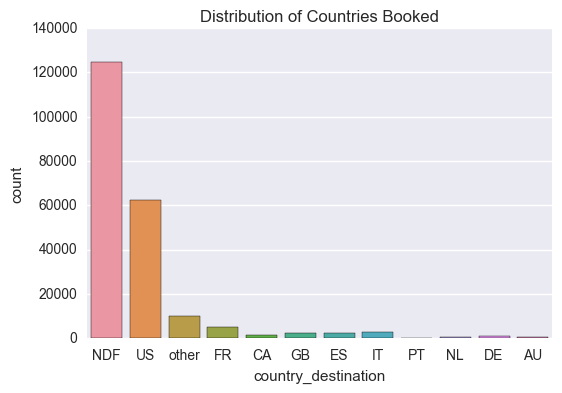

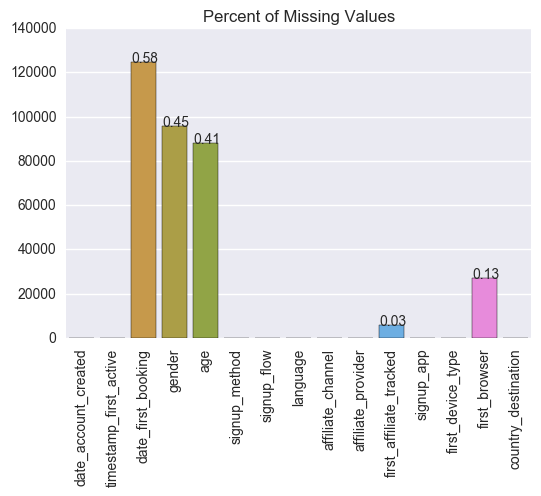

In [726]:
#distribution of countries
country_plot = sns.countplot(x='country_destination', data=all_data)
plt.title("Distribution of Countries Booked")
sns.plt.show()
#sns.barplot(x=all_data.country_destination.value_counts().index, y=all_data.country_destination.value_counts())

#number of NA
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=30)
plt.title("Percent of Missing Values")
plt.xticks(rotation=90)
total = float(len(all_data)) # one person per row 
for p in plot.patches:
    height = p.get_height()
    per = height/total
    if per > 0:
        plot.text(p.get_x(), height+3, '%1.2f'%(per))
sns.plt.show()


In [727]:
def remove_outliers(df, column, min_val, max_val):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<=min_val, col_values>=max_val), np.NaN, col_values)
    return df


In [728]:
#fix datatypes
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

print("Converting objects to categories...")
for categorical_feature in categorical_features:
   all_data[categorical_feature] = all_data[categorical_feature].astype('category')

print("Fixing timestamps...")
all_data['date_account_created'] = pd.to_datetime(all_data['date_account_created'], format='%Y-%m-%d')
all_data['timestamp_first_active'] = pd.to_datetime(all_data['timestamp_first_active'], format='%Y%m%d%H%M%S')
all_data['date_account_created'].fillna(all_data.timestamp_first_active, inplace=True)

all_data.head()

Converting objects to categories...
Fixing timestamps...


,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,2009-03-19 04:32:55,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Fixing age column...


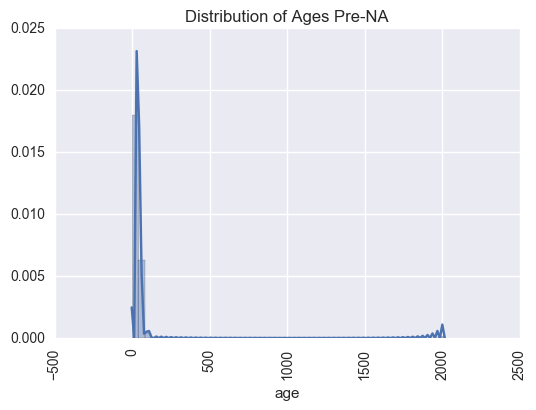

Any NA values in age? True
Imputing missing data with mean age
Any NA values in age? False


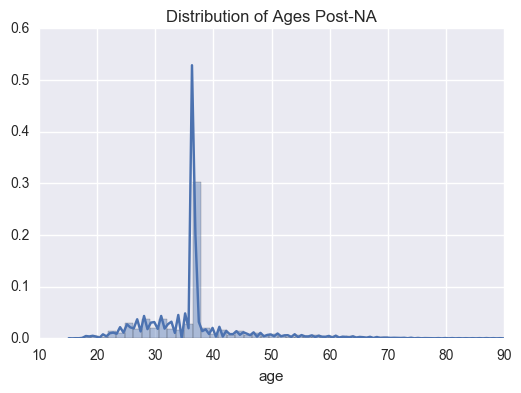

In [729]:
#observe age NA
print ("Fixing age column...")

pre_age_plot = sns.distplot(all_data.age.dropna(), bins =50 )
plt.title("Distribution of Ages Pre-NA")
plt.xticks(rotation=90)
sns.plt.show()

all_data = remove_outliers(df=all_data, column='age', min_val=15, max_val=90)
print "Any NA values in age?", all_data['age'].isnull().values.any()
mean_age = np.mean(all_data['age'].loc[all_data['age'].notnull()])
print "Imputing missing data with mean age"
all_data['age'].fillna(mean_age, inplace=True)

print "Any NA values in age?", all_data['age'].isnull().values.any()
post_age_plot =sns.distplot(all_data.age, bins =50 )
plt.title("Distribution of Ages Post-NA")
sns.plt.show()


# all_data.loc[all_data.age > 90, 'age'] = np.nan
# all_data.loc[all_data.age < 19, 'age'] = np.nan
# post_age_plot =sns.distplot(all_data.age.dropna(), bins =50 )
# plt.title("Distribution of Ages Post-NA")
# # post_age_plot.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
# plt.xticks(rotation=90)
# sns.plt.show()



In [730]:
print("Fixing date_first_booking...")
all_data.drop('date_first_booking', axis=1, inplace=True)

print("Fixing first_affiliate_tracked...")
all_data['first_affiliate_tracked'].fillna(method = 'ffill', inplace = True)
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()
# print "Current NA count:", all_data['first_affiliate_tracked'].isnull().sum()
# all_data = all_data[all_data.first_affiliate_tracked.notnull()]
# print "New NA count:", all_data['first_affiliate_tracked'].isnull().sum()

print ("Fixing first_browser...")


Fixing date_first_booking...
Fixing first_affiliate_tracked...
Any NA values? False
Fixing first_browser...


In [731]:
#extracting date values 
# Add new date related fields
print("Adding new date fields...")
all_data['day_account_created'] = all_data['date_account_created'].dt.weekday
all_data['month_account_created'] = all_data['date_account_created'].dt.month
all_data['quarter_account_created'] = all_data['date_account_created'].dt.quarter
all_data['year_account_created'] = all_data['date_account_created'].dt.year
all_data['hour_first_active'] = all_data['timestamp_first_active'].dt.hour
all_data['day_first_active'] = all_data['timestamp_first_active'].dt.weekday
all_data['month_first_active'] = all_data['timestamp_first_active'].dt.month
all_data['quarter_first_active'] = all_data['timestamp_first_active'].dt.quarter
all_data['year_first_active'] = all_data['timestamp_first_active'].dt.year
all_data['created_less_active'] = (all_data['date_account_created'] - all_data['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active']
for column in columns_to_drop:
    if column in all_data.columns:
        all_data.drop(column, axis=1, inplace=True)

all_data.head()
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()

Adding new date fields...


,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,day_account_created,month_account_created,quarter_account_created,year_account_created,hour_first_active,day_first_active,month_first_active,quarter_first_active,year_first_active,created_less_active
0,NaN,36.457362,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,6,2,2010,4,3,3,1,2009,465
1,MALE,38.000000,facebook,0,en,seo,google,untracked,Web,Mac Desktop,...,2,5,2,2011,17,5,5,2,2009,731
2,FEMALE,56.000000,basic,3,en,direct,direct,untracked,Web,Windows Desktop,...,1,9,3,2010,23,1,6,2,2009,475
3,FEMALE,42.000000,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,12,4,2011,6,5,10,4,2009,764
4,NaN,41.000000,basic,0,en,direct,direct,untracked,Web,Mac Desktop,...,1,9,3,2010,6,1,12,4,2009,279


In [752]:
x = all_data.loc[all_data['first_browser'].value_counts()<10]

# browser_data = all_data.loc[all_data['first_browser'].value_counts()>10]
# print browser_data


IndexingError: Unalignable boolean Series key provided

## Random Forest Attempt 1
### 10 trees. No one-hot encoding.

In [733]:
n_train = int((0.7*len(all_data)))
# all_data.index
#randomize sampling
np.random.seed(0) 
all_data = all_data.reindex(np.random.permutation(all_data.index))
x_train, x_train_target = all_data[:n_train], all_data.country_destination[:n_train]
x_test, x_test_target = all_data[n_train:], all_data.country_destination[n_train:]

print "X train size is", x_train.shape
print "X test size is", x_test.shape
x_train.head()



X train size is (149415, 22)
X test size is (64036, 22)


,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,day_account_created,month_account_created,quarter_account_created,year_account_created,hour_first_active,day_first_active,month_first_active,quarter_first_active,year_first_active,created_less_active
76214,MALE,43.000000,facebook,0,en,direct,direct,linked,Web,Mac Desktop,...,4,5,2,2013,18,4,5,2,2013,-1
197283,FEMALE,35.000000,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,...,4,5,2,2014,23,4,5,2,2014,-1
65429,NaN,36.457362,basic,0,en,direct,direct,linked,Web,Mac Desktop,...,4,3,1,2013,15,4,3,1,2013,-1
151272,NaN,36.457362,basic,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,2,1,2014,6,0,2,1,2014,-1
137127,FEMALE,29.000000,basic,0,en,direct,direct,untracked,Web,Windows Desktop,...,2,1,1,2014,19,2,1,1,2014,-1


In [681]:
# ?RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=10, verbose=1)
# rf.fit(x_train, x_train_target)